# UROP 1100 - Victoria A. Junaedi
Code from https://github.com/BenjiKCF/Neural-Network-with-Financial-Time-Series-Data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
import pandas as pd
from pandas import datetime
import math, time
from sklearn import preprocessing
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import pandas_datareader.data as web
import h5py
from keras import backend as K
import quandl

Using TensorFlow backend.


#  Getting the data from Quandl
and determining other parameters

In [49]:
quandl.ApiConfig.api_key = 'ETPyWitxJn3wiSRvxUjk'
seq_len = 22
shape = [seq_len, 9, 1]
neurons = [256, 256, 32, 1]
dropout = 0.3
decay = 0.5
epochs = 300
stock_name = 'CathayPacific'

# Pulling the data from Quandl

In [50]:
def get_stock_data(stock_name, normalize=True, ma=[]):
    """
    Return a dataframe of that stock and normalize all the values. 
    (Optional: create moving average)
    """
#     df = quandl.get_table('HKEX', ticker = stock_name)
# Date,Nominal Price,Net Change,Change (%),Bid,Ask,P/E(x),High,Low,Previous Close,Share Volume ('000),Turnover ('000),Lot Size

    df = quandl.get("HKEX/00293", authtoken="ETPyWitxJn3wiSRvxUjk")
    df.drop(['Net Change','P/E(x)', 'Bid', 'Ask', 'Lot Size', 'Turnover (\'000)'], 1, inplace=True)
#     df.set_index('Date', inplace=True)
    
    # Renaming all the columns so that we can use the old version code
    df.rename(columns={'Nominal Price': 'Open','Share Volume (\'000)': 'Volume', 'Previous Close': 'Adj Close', 'Change (%)': 'Pct'}, inplace=True)
    
#     # Percentage change
#     df['Pct'] = df['Adj Close'].pct_change()
    df.dropna(inplace=True)
    
    # Moving Average    
    if ma != []:
        for moving in ma:
            df['{}ma'.format(moving)] = df['Adj Close'].rolling(window=moving).mean()
    df.dropna(inplace=True)
    
    if normalize:
        min_max_scaler = preprocessing.MinMaxScaler()
        df['Open'] = min_max_scaler.fit_transform(df.Open.values.reshape(-1,1))
        df['High'] = min_max_scaler.fit_transform(df.High.values.reshape(-1,1))
        df['Low'] = min_max_scaler.fit_transform(df.Low.values.reshape(-1,1))
        df['Volume'] = min_max_scaler.fit_transform(df.Volume.values.reshape(-1,1))
        df['Adj Close'] = min_max_scaler.fit_transform(df['Adj Close'].values.reshape(-1,1))
        df['Pct'] = min_max_scaler.fit_transform(df['Pct'].values.reshape(-1,1))
        if ma != []:
            for moving in ma:
                df['{}ma'.format(moving)] = min_max_scaler.fit_transform(df['{}ma'.format(moving)].values.reshape(-1,1))  
                
    # Move Adj Close to the rightmost for the ease of training
    adj_close = df['Adj Close']
    df.drop(labels=['Adj Close'], axis=1, inplace=True)
    df = pd.concat([df, adj_close], axis=1)
      
    return df

In [51]:
df = get_stock_data(stock_name, ma=[50, 100, 200]) # putting 50 days, 100 days, and 200 days moving average

# Visualizing the data

In [52]:
def plot_stock(df):
    print(df.head())
    plt.subplot(211)
    plt.plot(df['Adj Close'], color='red', label='Adj Close')
    plt.legend(loc='best')
    plt.subplot(212)
    plt.plot(df['Pct'], color='blue', label='Percentage change')
    plt.legend(loc='best')
    plt.show()

                Open       Pct      High       Low    Volume      50ma  \
Date                                                                     
2014-12-19  0.628352  0.350632  0.623352  0.629412  0.062676  0.560608   
2014-12-22  0.649425  0.375036  0.629002  0.649020  0.018500  0.564995   
2014-12-23  0.632184  0.350439  0.627119  0.643137  0.020874  0.570337   
2014-12-24  0.634100  0.258898  0.623352  0.643137  0.009915  0.575722   
2014-12-29  0.636015  0.258898  0.629002  0.654902  0.017850  0.581759   

               100ma     200ma  Adj Close  
Date                                       
2014-12-19  0.525715  0.569391   0.639469  
2014-12-22  0.527974  0.570507   0.622391  
2014-12-23  0.530558  0.571352   0.643264  
2014-12-24  0.533049  0.572354   0.626186  
2014-12-29  0.535634  0.573413   0.628083  


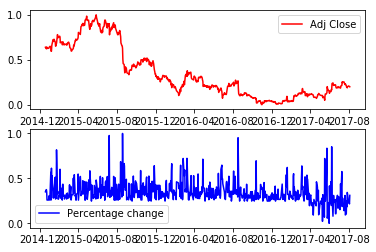

In [53]:
plot_stock(df)

# Split training and testing

In [54]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    print ("Amount of features = {}".format(amount_of_features))
    data = stock.as_matrix()
    sequence_length = seq_len + 1 # index starting from 0
    result = []

    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 22days

    result = np.array(result)
    row = round(0.8 * result.shape[0]) # 80% split
    print ("Amount of training data = {}".format(round(0.9 * result.shape[0])))
    print ("Amount of testing data = {}".format(round(0.1 * result.shape[0])))

    train = result[:int(row), :] # 90% date
    X_train = train[:, :-1] # all data until day m
    y_train = train[:, -1][:,-1] # day m + 1 adjusted close price

    X_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))

    return [X_train, y_train, X_test, y_test]

In [55]:
X_train, y_train, X_test, y_test = load_data(df, seq_len)

Amount of features = 9
Amount of training data = 558
Amount of testing data = 62


In [56]:
def build_model(shape, neurons, dropout, decay):
    model = Sequential()

    model.add(LSTM(neurons[0], input_shape=(shape[0], shape[1]), return_sequences=True))
    model.add(Dropout(dropout))

    model.add(LSTM(neurons[1], input_shape=(shape[0], shape[1]), return_sequences=False))
    model.add(Dropout(dropout))

    model.add(Dense(neurons[2],kernel_initializer="uniform",activation='relu'))
    model.add(Dense(neurons[3],kernel_initializer="uniform",activation='linear'))
    # model = load_model('my_LSTM_stock_model1000.h5')
    adam = keras.optimizers.Adam(decay=decay)
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [59]:
model = build_model(shape, neurons, dropout, decay)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 22, 256)           272384    
_________________________________________________________________
dropout_7 (Dropout)          (None, 22, 256)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 805,953
Trainable params: 805,953
Non-trainable params: 0
_________________________________________________________________


In [67]:
model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=epochs,
    validation_split=0.33,
    verbose=1)

Train on 332 samples, validate on 164 samples
Epoch 1/300
332/332 [==============================] - 6s - loss: 0.0079 - acc: 0.0030 - val_loss: 0.0348 - val_acc: 0.0061
Epoch 2/300
332/332 [==============================] - 3s - loss: 0.0105 - acc: 0.0030 - val_loss: 0.0340 - val_acc: 0.0061
Epoch 3/300
332/332 [==============================] - 2s - loss: 0.0071 - acc: 0.0030 - val_loss: 0.0327 - val_acc: 0.0061
Epoch 4/300
332/332 [==============================] - 2s - loss: 0.0079 - acc: 0.0030 - val_loss: 0.0326 - val_acc: 0.0061
Epoch 5/300
332/332 [==============================] - 2s - loss: 0.0086 - acc: 0.0030 - val_loss: 0.0342 - val_acc: 0.0061
Epoch 6/300
332/332 [==============================] - 2s - loss: 0.0058 - acc: 0.0030 - val_loss: 0.0362 - val_acc: 0.0061
Epoch 7/300
332/332 [==============================] - 2s - loss: 0.0072 - acc: 0.0030 - val_loss: 0.0371 - val_acc: 0.0061
Epoch 8/300
332/332 [==============================] - 2s - loss: 0.0072 - acc: 0.0030

332/332 [==============================] - 2s - loss: 0.0033 - acc: 0.0030 - val_loss: 0.0305 - val_acc: 0.0061
Epoch 67/300
332/332 [==============================] - 2s - loss: 0.0030 - acc: 0.0030 - val_loss: 0.0305 - val_acc: 0.0061
Epoch 68/300
332/332 [==============================] - 2s - loss: 0.0035 - acc: 0.0030 - val_loss: 0.0291 - val_acc: 0.0061
Epoch 69/300
332/332 [==============================] - 2s - loss: 0.0030 - acc: 0.0030 - val_loss: 0.0285 - val_acc: 0.0061
Epoch 70/300
332/332 [==============================] - 2s - loss: 0.0035 - acc: 0.0030 - val_loss: 0.0295 - val_acc: 0.0061
Epoch 71/300
332/332 [==============================] - 2s - loss: 0.0033 - acc: 0.0030 - val_loss: 0.0296 - val_acc: 0.0061
Epoch 72/300
332/332 [==============================] - 2s - loss: 0.0035 - acc: 0.0030 - val_loss: 0.0289 - val_acc: 0.0061
Epoch 73/300
332/332 [==============================] - 2s - loss: 0.0032 - acc: 0.0030 - val_loss: 0.0286 - val_acc: 0.0061
Epoch 74/300


332/332 [==============================] - 2s - loss: 0.0026 - acc: 0.0030 - val_loss: 0.0257 - val_acc: 0.0061
Epoch 132/300
332/332 [==============================] - 2s - loss: 0.0031 - acc: 0.0030 - val_loss: 0.0271 - val_acc: 0.0061
Epoch 133/300
332/332 [==============================] - 2s - loss: 0.0028 - acc: 0.0030 - val_loss: 0.0254 - val_acc: 0.0061
Epoch 134/300
332/332 [==============================] - 2s - loss: 0.0029 - acc: 0.0030 - val_loss: 0.0220 - val_acc: 0.0061
Epoch 135/300
332/332 [==============================] - 2s - loss: 0.0029 - acc: 0.0030 - val_loss: 0.0231 - val_acc: 0.0061
Epoch 136/300
332/332 [==============================] - 2s - loss: 0.0029 - acc: 0.0030 - val_loss: 0.0267 - val_acc: 0.0061
Epoch 137/300
332/332 [==============================] - 2s - loss: 0.0032 - acc: 0.0030 - val_loss: 0.0250 - val_acc: 0.0061
Epoch 138/300
332/332 [==============================] - 2s - loss: 0.0024 - acc: 0.0030 - val_loss: 0.0218 - val_acc: 0.0061
Epoch 

332/332 [==============================] - 2s - loss: 0.0026 - acc: 0.0030 - val_loss: 0.0195 - val_acc: 0.0061
Epoch 197/300
332/332 [==============================] - 2s - loss: 0.0026 - acc: 0.0030 - val_loss: 0.0203 - val_acc: 0.0061
Epoch 198/300
332/332 [==============================] - 2s - loss: 0.0023 - acc: 0.0030 - val_loss: 0.0221 - val_acc: 0.0061
Epoch 199/300
332/332 [==============================] - 2s - loss: 0.0028 - acc: 0.0030 - val_loss: 0.0209 - val_acc: 0.0061
Epoch 200/300
332/332 [==============================] - 2s - loss: 0.0022 - acc: 0.0030 - val_loss: 0.0206 - val_acc: 0.0061
Epoch 201/300
332/332 [==============================] - 2s - loss: 0.0026 - acc: 0.0030 - val_loss: 0.0229 - val_acc: 0.0061
Epoch 202/300
332/332 [==============================] - 2s - loss: 0.0025 - acc: 0.0030 - val_loss: 0.0224 - val_acc: 0.0061
Epoch 203/300
332/332 [==============================] - 2s - loss: 0.0024 - acc: 0.0030 - val_loss: 0.0202 - val_acc: 0.0061
Epoch 

332/332 [==============================] - 2s - loss: 0.0022 - acc: 0.0030 - val_loss: 0.0208 - val_acc: 0.0061
Epoch 262/300
332/332 [==============================] - 2s - loss: 0.0024 - acc: 0.0030 - val_loss: 0.0198 - val_acc: 0.0061
Epoch 263/300
332/332 [==============================] - 2s - loss: 0.0020 - acc: 0.0030 - val_loss: 0.0207 - val_acc: 0.0061
Epoch 264/300
332/332 [==============================] - 2s - loss: 0.0020 - acc: 0.0030 - val_loss: 0.0212 - val_acc: 0.0061
Epoch 265/300
332/332 [==============================] - 2s - loss: 0.0019 - acc: 0.0030 - val_loss: 0.0207 - val_acc: 0.0061
Epoch 266/300
332/332 [==============================] - 2s - loss: 0.0023 - acc: 0.0030 - val_loss: 0.0185 - val_acc: 0.0061
Epoch 267/300
332/332 [==============================] - 2s - loss: 0.0019 - acc: 0.0030 - val_loss: 0.0185 - val_acc: 0.0061
Epoch 268/300
332/332 [==============================] - 2s - loss: 0.0021 - acc: 0.0030 - val_loss: 0.0200 - val_acc: 0.0061
Epoch 

# Result

In [68]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]

model_score(model, X_train, y_train, X_test, y_test)

Train Score: 0.00735 MSE (0.09 RMSE)
Test Score: 0.01370 MSE (0.12 RMSE)


(0.0073529773301655244, 0.013702700447831903)

# Prediction vs Real Results

In [69]:
def percentage_difference(model, X_test, y_test):
    percentage_diff=[]

    p = model.predict(X_test)
    for u in range(len(y_test)): # for each data index in test data
        pr = p[u][0] # pr = prediction on day u

        percentage_diff.append((pr-y_test[u]/pr)*100)
    return p

In [70]:
p = percentage_difference(model, X_test, y_test)

In [71]:
def denormalize(normalized_value):
    """
    Return a dataframe of that stock and normalize all the values. 
    (Optional: create moving average)
    """
    df = quandl.get("HKEX/00293", authtoken="ETPyWitxJn3wiSRvxUjk")
    df.drop(['Net Change','P/E(x)', 'Bid', 'Ask', 'Lot Size', 'Turnover (\'000)'], 1, inplace=True)
#     df.set_index('Date', inplace=True)
    
    # Renaming all the columns so that we can use the old version code
    df.rename(columns={'Nominal Price': 'Open','Share Volume (\'000)': 'Volume', 'Previous Close': 'Adj Close', 'Change (%)': 'Pct'}, inplace=True)
    
    df.dropna(inplace=True)
    df = df['Adj Close'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)

    #return df.shape, p.shape
    min_max_scaler = preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(df)
    new = min_max_scaler.inverse_transform(normalized_value)
      
    return new

In [73]:
def plot_result(stock_name, normalized_value_p, normalized_value_y_test):
    newp = denormalize(normalized_value_p)
    newy_test = denormalize(normalized_value_y_test)
    plt2.plot(newp, color='red', label='Prediction')
    plt2.plot(newy_test,color='blue', label='Actual')
    plt2.legend(loc='best')
    plt2.title('The test result for {}'.format(stock_name))
    plt2.xlabel('Days')
    plt2.ylabel('Adjusted Close')
    plt2.show()

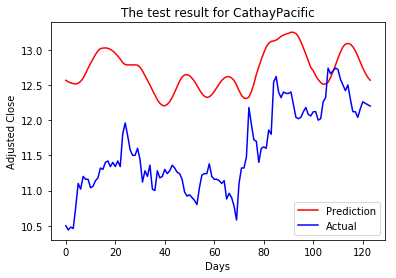

In [74]:
plot_result(stock_name, p, y_test)